In [1]:
from stellargraph.data import EdgeSplitter
import numpy as np
from sklearn.model_selection import train_test_split
import multiprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.decomposition import PCA

import stellargraph as sg
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objs as go
from plotly.offline import plot
from sklearn.metrics import confusion_matrix


## Constansok

In [2]:
# ['0', '107']
edge_path = 'facebook/0.edges' # 0.edges

In [3]:
def create_mapping(path):
    with open(path, 'rt') as file:
        text = file.read()

    # Feldolgozom a sorokat
    connections = []
    from_list = []
    to_list = []
    for row in text.split('\n')[:-1]:
        a, b = [int(x) for x in row.split(' ')]
        connections.append((a, b))

        from_list.append(a)
        to_list.append(b)


    id_mapper = {}
    reverse_id_mapper = {}
    counter = 0
    for elem in from_list:
        if elem not in id_mapper.values():
            id_mapper[counter] = elem
            reverse_id_mapper[elem] = counter
            counter += 1

    for elem in to_list:
        if elem not in id_mapper.values():
            id_mapper[counter] = elem
            reverse_id_mapper[elem] = counter
            counter += 1

    scaled_connections = []
    for first, second in connections:
        first_scaled = reverse_id_mapper[first]
        second_scaled = reverse_id_mapper[second]

        scaled_connections.append((first_scaled, second_scaled))

    return id_mapper, reverse_id_mapper, scaled_connections

def read_graph(path, map = True):
    id_mapper_ = None
    reverse_id_mapper_ = None

    if map:
        id_mapper_, reverse_id_mapper_, edges = create_mapping(path)
        G_ = nx.Graph()
        G_.add_edges_from(edges)
    else:
        G_ = nx.read_edgelist(path, nodetype=int, create_using=nx.Graph())

    G_ = sg.StellarGraph.from_networkx(G)

    return G_, id_mapper_, reverse_id_mapper_

In [4]:
G, id_mapper, reverse_id_mapper = read_graph(edge_path, map =True)
print(G.info())


# for edge in G.edges():
#     G[edge[0]][edge[1]]['weight'] = 1

StellarGraph: Undirected multigraph
 Nodes: 333, Edges: 2519

 Node types:
  default: [333]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [2519]
        Weights: all 1 (default)
        Features: none


## Start

In [5]:
edge_splitter_test = EdgeSplitter(G)

In [6]:
# Itt az edge_splitter tesztből vesz éleket, ezeket az examples_test,
# Majd vesz negatív éleket is, ezt szintén hozzárakja az examples_test-hez concatolva,
# a labels test az, hogy ez az él létezik-e vagy sem
# a graph test a gráf a maradék éllel
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(p=0.1, method="global")

** Sampled 251 positive and 251 negative edges. **


In [7]:
def print_graph_info(graph):
    print(graph.info())

In [8]:
print_graph_info(graph_test)

StellarGraph: Undirected multigraph
 Nodes: 333, Edges: 2268

 Node types:
  default: [333]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [2268]
        Weights: all 1 (default)
        Features: none


In [9]:
edge_splitter_train = EdgeSplitter(g=graph_test, g_master=G)
graph_train, examples, labels = edge_splitter_train.train_test_split(p=0.1, method="global")

(examples_train, examples_model_selection, labels_train, labels_model_selection,)\
                                        = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

** Sampled 226 positive and 226 negative edges. **


In [10]:
print_graph_info(graph_train)

StellarGraph: Undirected multigraph
 Nodes: 333, Edges: 2042

 Node types:
  default: [333]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [2042]
        Weights: all 1 (default)
        Features: none


In [11]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,339,Train Graph,Test Graph,Train the Link Classifier
Model Selection,113,Train Graph,Test Graph,Select the best Link Classifier model
Test set,502,Test Graph,Full Graph,Evaluate the best Link Classifier


In [12]:
used_params = {
    'p': 1.0,
    'q': 0.6,
    'dimensions': 128,
    'num_walks': 100,
    'walk_length': 30,
    'window_size': 13,
    'num_iter': 5
}

In [13]:
# p = 1.0
# q = 1.0
# dimensions = 128
# num_walks = 60
# walk_length = 60
# window_size = 16
# num_iter = 5
workers = multiprocessing.cpu_count()

In [14]:
def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=used_params['num_walks'], length=used_params['walk_length'], p=used_params['p'], q=used_params['q'])
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        vector_size=used_params['dimensions'],
        window=used_params['window_size'],
        min_count=0,
        sg=1,
        workers=workers,
        epochs=used_params['num_iter'],
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [15]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 33300


In [16]:
# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]

# 2. training classifier
def train_link_prediction_model(
        link_examples, link_labels, get_embedding, binary_operator
):
    # Ezt akár lehet módosítani is más algoritmussal
    clf = link_prediction_classifier()

    # Itt távolságot számol a start és end pont embeddingje között
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    # Majd arra fitteli a modelt
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=4000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
        clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

In [17]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }

binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [18]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'operator_l2'


,ROC AUC score
name,
operator_hadamard,0.857051
operator_l1,0.963141
operator_l2,0.963462
operator_avg,0.738782


In [19]:
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 33300


In [20]:
test_score = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_l2': 0.9488420818717163


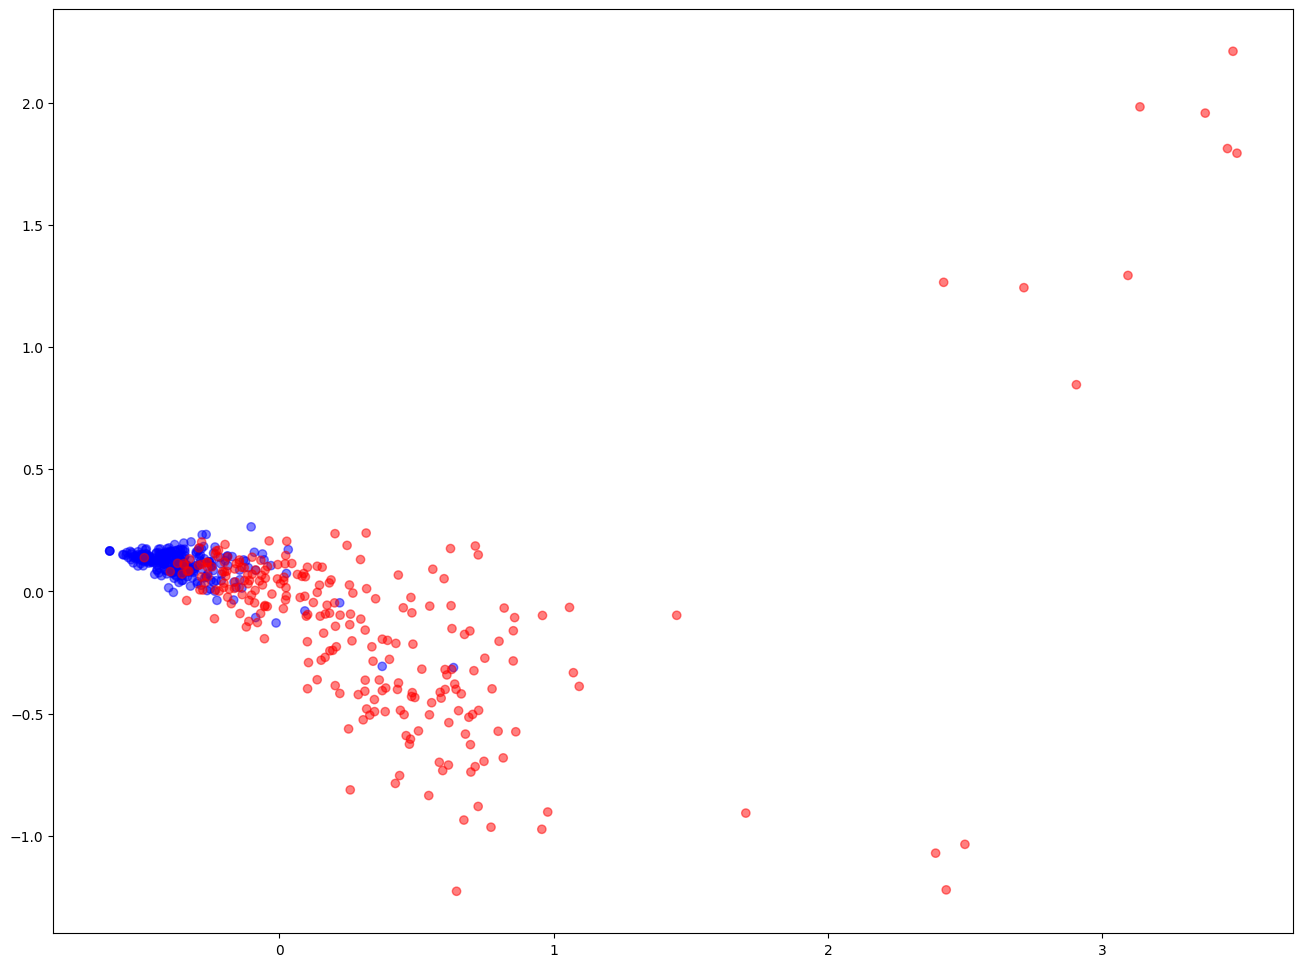

In [21]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
    )

## Inference

In [22]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 333, Edges: 2519

 Node types:
  default: [333]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [2519]
        Weights: all 1 (default)
        Features: none


In [23]:
edge_splitter_test = EdgeSplitter(G)
graph, X, y = edge_splitter_test.train_test_split(p=0.2, method="global")

embedding_all = node2vec_embedding(graph, "Test Graph")

** Sampled 503 positive and 503 negative edges. **
Number of random walks for 'Test Graph': 33300


In [24]:
model = train_link_prediction_model(X, y, embedding_all, operator_l2) # embedding_all maybe

In [25]:
nodes = list(G.nodes())
nodes.sort()

In [26]:
first_node = []
second_node = []
for node1 in nodes:
    for node2 in nodes:
        if node1 < node2:
            first_node.append(node1)
            second_node.append(node2)

In [27]:
prob_df = pd.DataFrame({'first_node': first_node, 'second_node': second_node})

In [28]:
processed_tmp = link_examples_to_features(prob_df.values, embedding_all, best_result['binary_operator'])

In [29]:
prob_df['prob'] = model.predict_proba(processed_tmp)[:,1]
prob_df['class'] = model.predict(processed_tmp)

In [30]:
prob_df = prob_df.set_index(['first_node', 'second_node'])

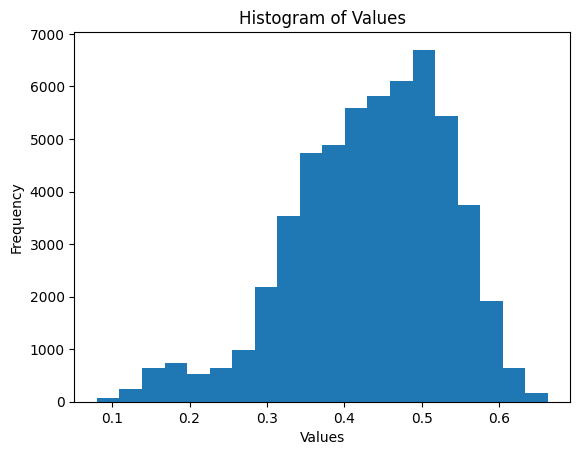

In [31]:
# Create a histogram
plt.hist(list(prob_df['prob']), bins=20)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()

In [32]:
graph_edges = [(min(u, v), max(u, v)) for u, v in G.edges()]
graph_df = pd.DataFrame(graph_edges, columns=['first_node', 'second_node'])

graph_df = graph_df.set_index(['first_node', 'second_node'])

graph_df['edge'] = 1

In [33]:
result_df = prob_df.join(graph_df, how = 'left')
result_df['edge'] = result_df['edge'].fillna(0)
result_df['pred_edge'] = result_df['prob'].apply(lambda x: 1 if x > 0.5 else 0)

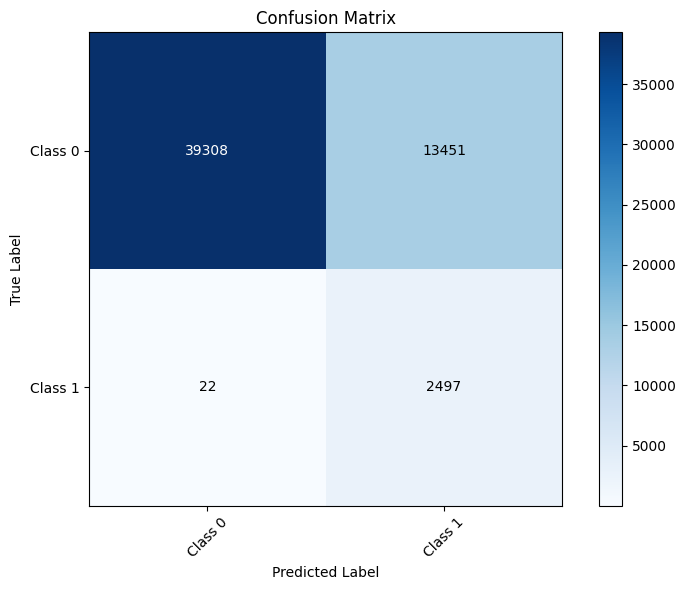

In [34]:

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    plt.show()


cm = confusion_matrix(result_df['edge'], result_df['pred_edge'])

# Define class labels (if applicable)
class_labels = ['Class 0', 'Class 1']

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=class_labels)

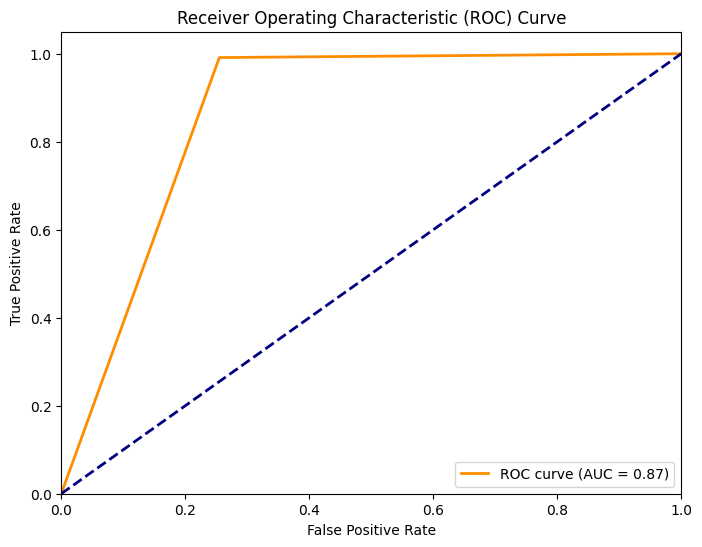

In [35]:
def plot_roc_curve(predictions_df):
    # Extract the 'Real', 'Pred', and 'Prob' columns
    ground_truth_values = predictions_df['edge'].tolist()
    predictions = predictions_df['pred_edge'].tolist()

    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(ground_truth_values, predictions)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = roc_auc_score(ground_truth_values, predictions)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Example usage:
plot_roc_curve(result_df)

In [36]:
offers = result_df[(result_df['edge'] == 0) & (result_df['pred_edge'] == 1)].reset_index()

In [37]:
result_dict = {node: None for node in G.nodes()}
recommendation_number = 5

for node in G.nodes():
    filtered_offers = offers[(offers['first_node'] == node) | (offers['second_node'] == node)].copy()

    filtered_offers['neighbor'] = filtered_offers.apply(lambda x: x['first_node'] if x['first_node'] != node else x['second_node'], axis = 1).astype('int')

    result_dict[node] = list(filtered_offers.sort_values('prob', ascending = False)['neighbor'][:recommendation_number])

In [46]:
# result_dict

what i want:

choose a node
plot all connection between this node and all of its neighbors
plot all connection between this node and all of the recommended nodes
plot all connections between the neighbors between each other and the recommended nodes

plot chosen node, recommended node, neighbor node with different color

In [45]:
chosen_node = 20

# Get the recommended nodes for the chosen node
recommendations = result_dict[chosen_node]

# Get the neighbors of the chosen node
neighbors = list(G.neighbors(chosen_node))

# Ez a rész nem kell, ezért kinullázom
recommendation_neighbors = []
for node in recommendations:
    t = list(G.neighbors(node))
    recommendation_neighbors += t

recommendation_neighbors = []

# Create a set of nodes in the subgraph
subgraph_nodes = set(recommendation_neighbors + recommendations + neighbors + [chosen_node])

# Create a subgraph from the set of nodes
subgraph = G.subgraph(list(subgraph_nodes)).to_networkx()

new_edges = [(chosen_node, recommendation) for recommendation in recommendations]

subgraph.add_edges_from(new_edges)

# Compute positions for the entire subgraph
pos = nx.spring_layout(subgraph)

# Define colors for nodes
node_colors = {
    **{n: 'green' for n in neighbors},           # Neighbor nodes color
    **{n: 'blue' for n in recommendation_neighbors},  # Neighbors of neighbors color
    **{n: 'yellow' for n in recommendations},   # Recommended nodes color
    chosen_node: 'red'            # Chosen node color
}

# Create nodes and edges for plotly
edge_trace_yellow = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='yellow'),  # Specify the edge color as yellow
    hoverinfo='none',
    mode='lines')

edge_trace_blue = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='green'),  # Specify the edge color as yellow
    hoverinfo='none',
    mode='lines')


edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for edge in subgraph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])


    if (edge[0] == chosen_node) and (edge[1] in recommendations) or (edge[1] == chosen_node) and (edge[0] in recommendations):
        edge_trace_yellow['x'] += tuple([x0, x1, None])  # Add to the yellow edge trace
        edge_trace_yellow['y'] += tuple([y0, y1, None])  # Add to the yellow edge trace

    elif (edge[0] == chosen_node) and (edge[1] in neighbors) or (edge[1] == chosen_node) and (edge[0] in neighbors):
        edge_trace_blue['x'] += tuple([x0, x1, None])  # Add to the yellow edge trace
        edge_trace_blue['y'] += tuple([y0, y1, None])  # Add to the yellow edge trace

    else:
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])

for node in subgraph.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['text'] += tuple([f'Node: {node}'])

# Create the plotly figure with both edge traces
fig = go.Figure(
    data=[edge_trace_yellow, edge_trace_blue, edge_trace, node_trace],
    layout=go.Layout(
        showlegend=False,
        hovermode='closest',
        margin=dict(b=0, l=0, r=0, t=0),
    )
)

# Update the node colors
fig.update_traces(marker=dict(color=[node_colors[node] for node in subgraph.nodes()]))

# Show the interactive plot
plot(fig, filename='interactive_network.html')

print("Chosen Node:", chosen_node)
print('Neighbor Nodes:', neighbors)
print('Recommendation Nodes:', result_dict[chosen_node])

Chosen Node: 20
Neighbor Nodes: [134, 34, 107, 78, 14, 10, 286, 213, 71, 257, 120, 85, 8, 165, 131, 63, 181, 31, 47, 84]
Recommendation Nodes: [15, 140, 3, 36, 65]
